## Importing

In [27]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn.metrics import mean_squared_error as mse

import os


## Datasets Preparation (Training)

In [28]:
def datasets_preparation ():

     # Dataset and date    
     ds_name = ('/results2/SalishSea/nowcast-green.202111/' + i + '/SalishSea_1d_' + '20' + str(i[5:7]) + str(dict_month[i[2:5]])+str(i[0:2]) + '_' + '20' + str(i[5:7]) + str(dict_month[i[2:5]]) + str(i[0:2]) + '_grid_T.nc')

     ds_bio_name = ('/results2/SalishSea/nowcast-green.202111/' + i + '/SalishSea_1d_'  + '20' + str(i[5:7]) + str(dict_month[i[2:5]])+str(i[0:2]) + '_' + '20' + str(i[5:7]) + str(dict_month[i[2:5]]) + str(i[0:2]) + '_biol_T.nc')

     ds = xr.open_dataset (ds_name)
     ds_bio = xr. open_dataset (ds_bio_name)

     temp_i1 = (ds.votemper.where(mask==1)[0,0:15] * ds.e3t.where(mask==1)
               [0,0:15]).sum('deptht', skipna = True, min_count = 15) / mesh.gdepw_0[0,15]
     temp_i2 = (ds.votemper.where(mask==1)[0,15:27] * ds.e3t.where(mask==1)
               [0,15:27]).sum('deptht', skipna = True, min_count = 12) / (mesh.gdepw_0[0,27] - mesh.gdepw_0[0,14])
     saline_i1 = (ds.vosaline.where(mask==1)[0,0:15] * ds.e3t.where(mask==1)
                    [0,0:15]).sum('deptht', skipna = True, min_count = 15) / mesh.gdepw_0[0,15]
     saline_i2 = (ds.vosaline.where(mask==1)[0,15:27] * ds.e3t.where(mask==1)
                    [0,15:27]).sum('deptht', skipna = True, min_count = 12) / (mesh.gdepw_0[0,27] - mesh.gdepw_0[0,14])

     diat_i = (ds_bio.diatoms.where(mask==1)[0,0:27] * ds.e3t.where(mask==1)
               [0,0:27]).sum('deptht', skipna = True, min_count = 27) / mesh.gdepw_0[0,27]
     flag_i = (ds_bio.flagellates.where(mask==1)[0,0:27] * ds.e3t.where(mask==1)
               [0,0:27]).sum('deptht', skipna = True, min_count = 27) / mesh.gdepw_0[0,27]

     return (temp_i1, temp_i2, saline_i1, saline_i2, diat_i, flag_i)


## Regressor

In [29]:
def regressor (inputs, targets, variable_name):
    
    inputs = inputs.transpose()
    
    # Regressor
    scale = preprocessing.StandardScaler()
    inputs2 = scale.fit_transform(inputs)
    X_train, X_test, y_train, y_test = train_test_split(inputs2, targets)

    extra_tree = ExtraTreeRegressor(criterion='poisson')
    regr = BaggingRegressor(extra_tree, n_estimators=10, max_features=4).fit(X_train, y_train)

    outputs_test = regr.predict(X_test)

    m = scatter_plot(y_test, outputs_test, variable_name + ' (Testing dataset)') 
    r = np.round(np.corrcoef(y_test, outputs_test)[0][1],3)
    rms = np.round(mse(y_test, outputs_test),4)
    

    return (r, rms, m, regr)

# Printing

In [30]:
def printing (targets, outputs, m):

    print ('The amount of data points is', outputs.size)
    print ('The slope of the best fitting line is ', np.round(m,3))
    print ('The correlation coefficient is:', np.round(np.corrcoef(targets, outputs)[0][1],3))
    print (' The mean square error is:', np.round(mse(targets,outputs),5))


## Scatter Plot

In [31]:
def scatter_plot(targets, outputs, variable_name):

    # compute slope m and intercept b
    m, b = np.polyfit(targets, outputs, deg=1)

    printing (targets, outputs, m)
    
    fig, ax = plt.subplots()

    plt.scatter(targets,outputs, alpha = 0.2, s = 10)
    plt.xlabel('targets')
    plt.ylabel('outputs')

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # plot fitted y = m*x + b
    plt.axline(xy1=(0, b), slope=m, color='r')

    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    ax.plot(lims, lims,linestyle = '--',color = 'k')

    fig.suptitle(str(year) + ', ' + variable_name)

    plt.show()

    return (m)


## Plotting

In [32]:
def plotting (variable, name):

    plt.plot(years,variable, marker = '.', linestyle = '')
    plt.legend(['diatom','flagellate'])
    plt.xlabel('Years')
    plt.ylabel(name)
    plt.show()

## Regressor 2

In [33]:
def regressor2 (inputs, targets, variable_name):
    
    inputs = inputs.transpose()
    
    # Regressor
    scale = preprocessing.StandardScaler()
    inputs2 = scale.fit_transform(inputs)

    outputs_test = regr.predict(inputs2)

    m = scatter_plot(targets, outputs_test, variable_name + ' (Testing dataset)') 
    r = np.round(np.corrcoef(targets, outputs_test)[0][1],3)
    rms = np.round(mse(targets, outputs_test),4)

    return (r, rms, m)

## Training of 2007

Gathering days for year 2011
Done gathering, building the prediction model


The amount of data points is 871482
The slope of the best fitting line is  0.908
The correlation coefficient is: 0.958
 The mean square error is: 0.00199


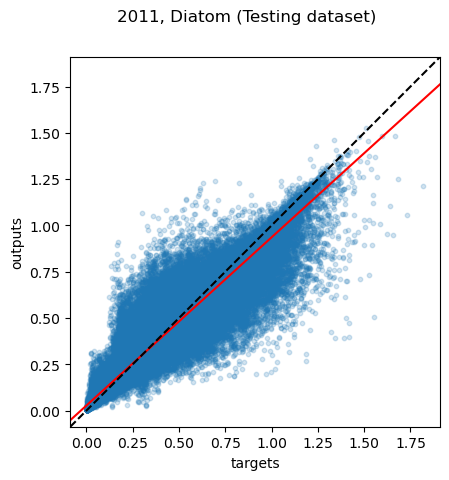

In [34]:
dict_month = {'jan': '01',
         'feb': '02',
         'mar': '03',
         'apr': '04',
         'may': '05',
         'jun': '06',
         'jul': '07',
         'aug': '08',
         'sep': '09',
         'oct': '10',
         'nov': '11',
         'dec': '12'}

path = os.listdir('/results2/SalishSea/nowcast-green.202111/')

# Open the mesh mask
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
mask = mesh.tmask.to_numpy()

year = 2011

year_str = str(year)[2:4]

folders = [x for x in path if ((x[2:5]=='mar' or x[2:5]=='apr' or (x[2:5]=='feb' and x[0:2] > '14')) and (x[5:7]==year_str))]
indx_dates=(np.argsort(pd.to_datetime(folders, format="%d%b%y")))
folders = [folders[i] for i in indx_dates]

drivers_all = np.array([[],[],[],[]])
diat_all = np.array([])

print ('Gathering days for year ' + str(year))

for i in folders:

    temp_i1, temp_i2, saline_i1, saline_i2, diat_i, flag_i = datasets_preparation()

    drivers = np.stack([np.ravel(temp_i1), np.ravel(temp_i2), np.ravel(saline_i1), np.ravel(saline_i2)])
    indx = np.where(~np.isnan(drivers).any(axis=0))
    drivers = drivers[:,indx[0]]
    drivers_all = np.concatenate((drivers_all,drivers),axis=1)

    diat = np.ravel(diat_i)
    diat = diat[indx[0]]
    diat_all = np.concatenate((diat_all,diat))

print ('Done gathering, building the prediction model')
print ('\n')

r, rms, m, regr = regressor(drivers_all, diat_all, 'Diatom')



## Other Years

Gathering days for year 2007
The amount of data points is 3485925
The slope of the best fitting line is  0.479
The correlation coefficient is: 0.511
 The mean square error is: 0.02418


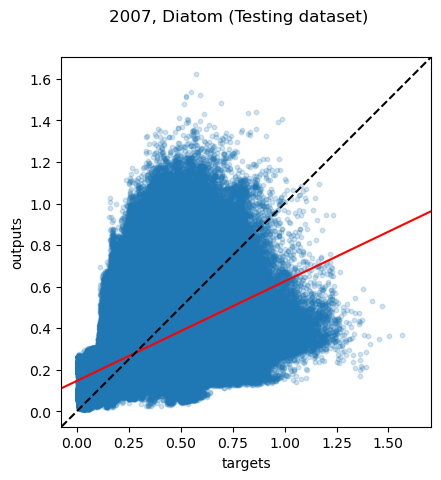

Gathering days for year 2008
The amount of data points is 3532404
The slope of the best fitting line is  0.598
The correlation coefficient is: 0.577
 The mean square error is: 0.01982


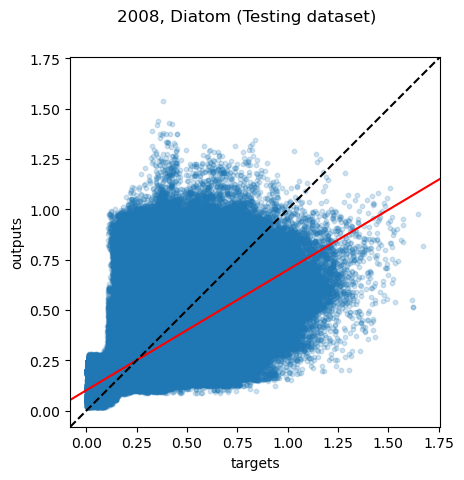

Gathering days for year 2009
The amount of data points is 3485925
The slope of the best fitting line is  0.538
The correlation coefficient is: 0.671
 The mean square error is: 0.0251


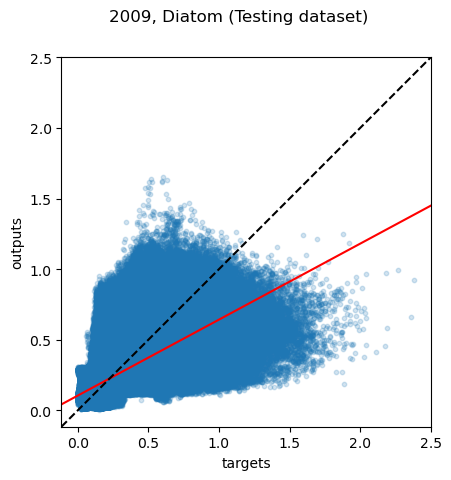

Gathering days for year 2010
The amount of data points is 3485925
The slope of the best fitting line is  0.451
The correlation coefficient is: 0.468
 The mean square error is: 0.02277


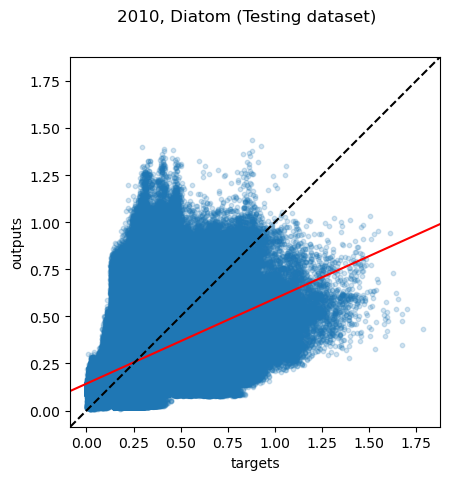

Gathering days for year 2011
The amount of data points is 3485925
The slope of the best fitting line is  0.952
The correlation coefficient is: 0.984
 The mean square error is: 0.00078


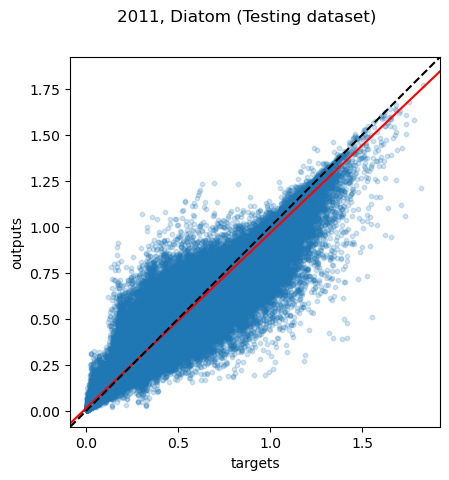

Gathering days for year 2012
The amount of data points is 3532404
The slope of the best fitting line is  0.602
The correlation coefficient is: 0.625
 The mean square error is: 0.01825


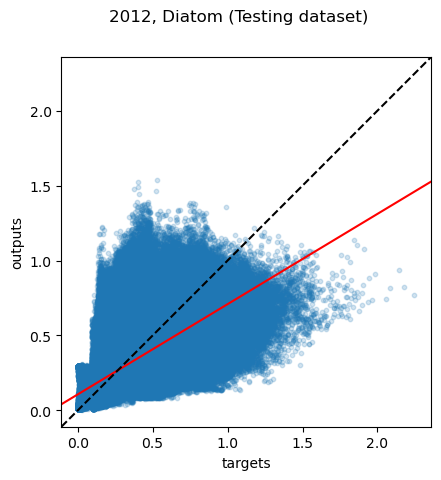

Gathering days for year 2013
The amount of data points is 3485925
The slope of the best fitting line is  0.368
The correlation coefficient is: 0.429
 The mean square error is: 0.03215


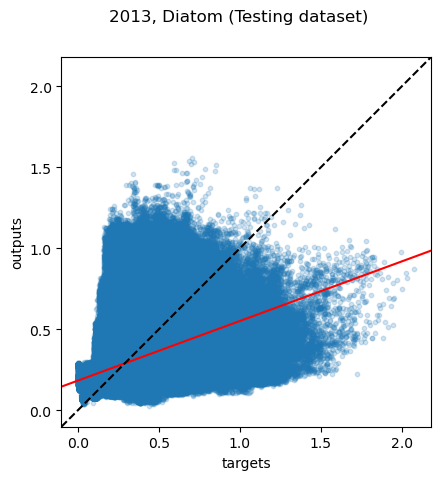

Gathering days for year 2014
The amount of data points is 3485925
The slope of the best fitting line is  0.391
The correlation coefficient is: 0.378
 The mean square error is: 0.0276


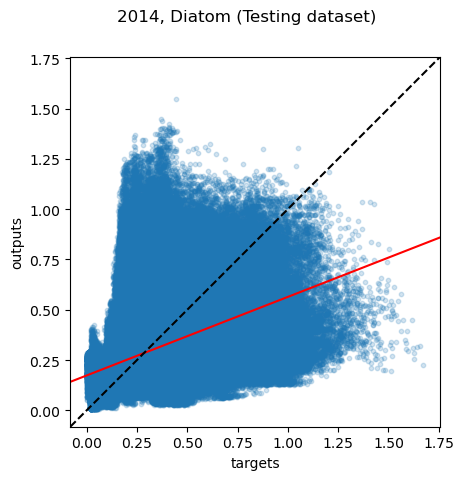

Gathering days for year 2015
The amount of data points is 3485925
The slope of the best fitting line is  0.166
The correlation coefficient is: 0.187
 The mean square error is: 0.03726


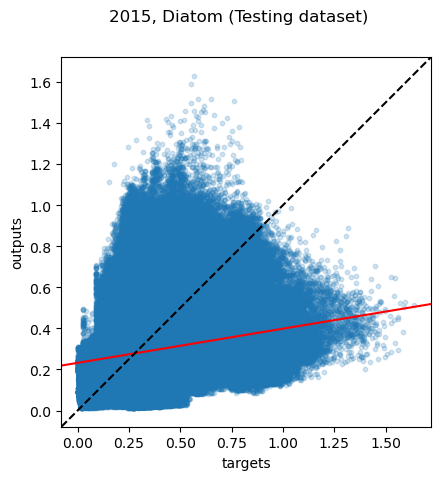

Gathering days for year 2016
The amount of data points is 3532404
The slope of the best fitting line is  0.179
The correlation coefficient is: 0.19
 The mean square error is: 0.04594


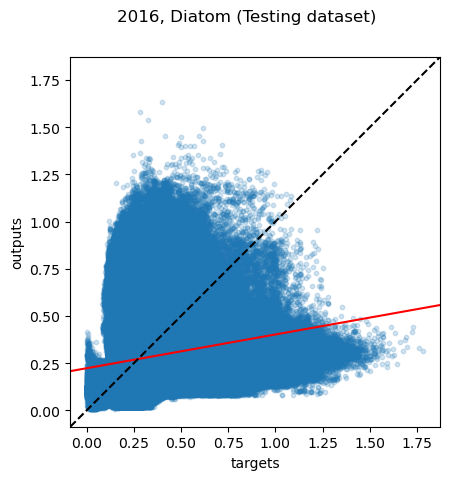

Gathering days for year 2017
The amount of data points is 3485925
The slope of the best fitting line is  0.531
The correlation coefficient is: 0.473
 The mean square error is: 0.02206


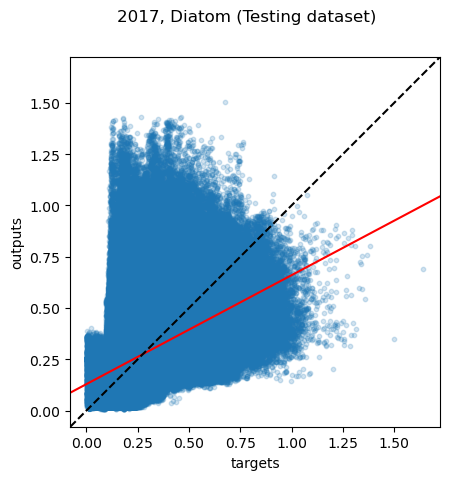

Gathering days for year 2018
The amount of data points is 3485925
The slope of the best fitting line is  0.31
The correlation coefficient is: 0.332
 The mean square error is: 0.03298


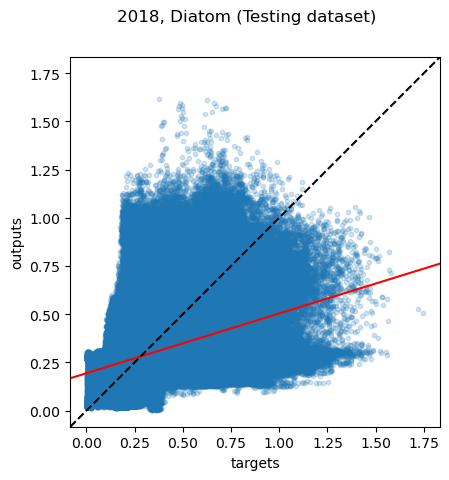

Gathering days for year 2019
The amount of data points is 3485925
The slope of the best fitting line is  0.251
The correlation coefficient is: 0.297
 The mean square error is: 0.04029


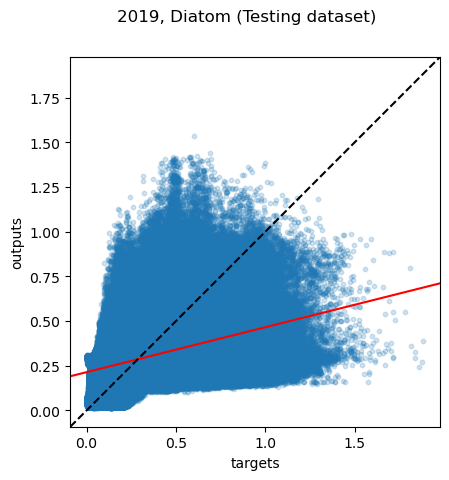

Gathering days for year 2020
The amount of data points is 3532404
The slope of the best fitting line is  0.193
The correlation coefficient is: 0.243
 The mean square error is: 0.05684


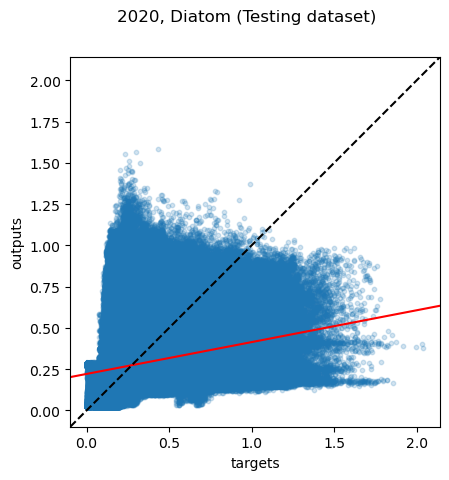

Gathering days for year 2021
The amount of data points is 3485925
The slope of the best fitting line is  0.348
The correlation coefficient is: 0.401
 The mean square error is: 0.03619


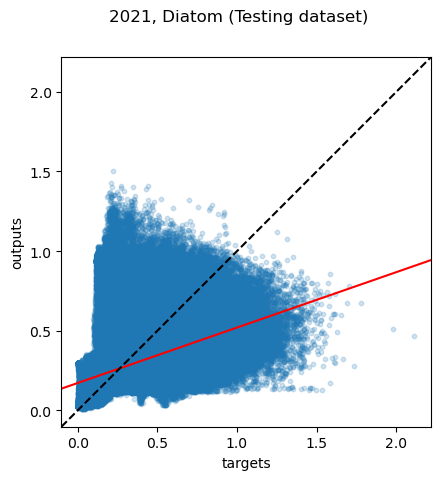

Gathering days for year 2022
The amount of data points is 3485925
The slope of the best fitting line is  0.51
The correlation coefficient is: 0.512
 The mean square error is: 0.02118


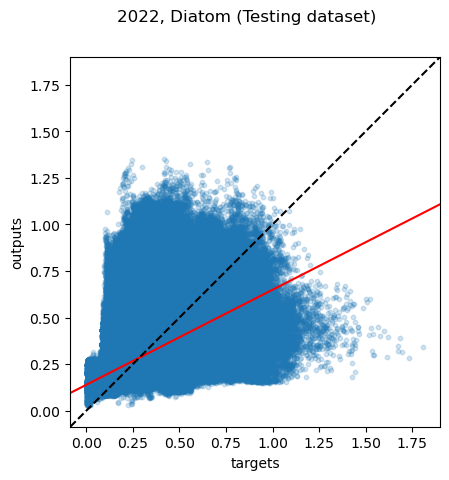

Gathering days for year 2023
The amount of data points is 3485925
The slope of the best fitting line is  0.212
The correlation coefficient is: 0.268
 The mean square error is: 0.0322


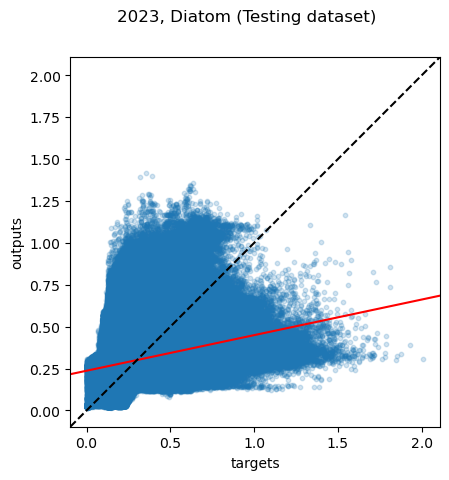

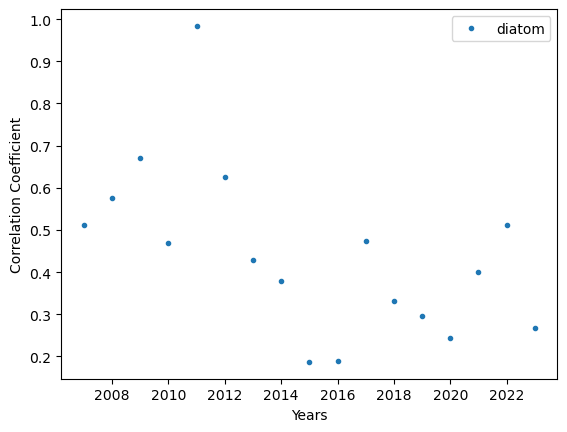

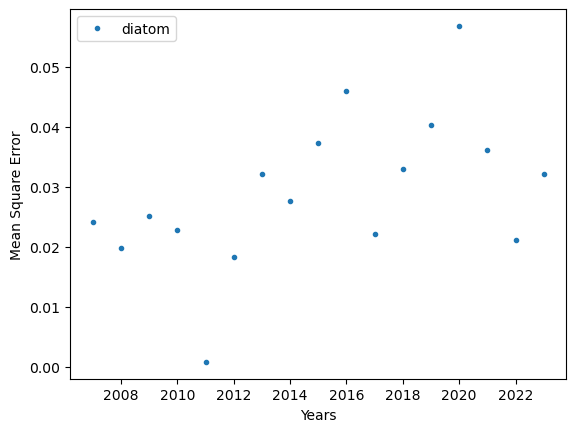

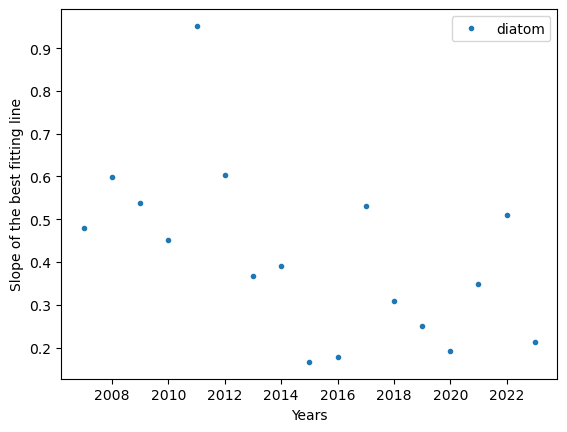

In [35]:
years = range (2007,2024)

r_all = []
rms_all = []
slope_all = []

for year in range (2007,2024):

    year_str = str(year)[2:4]

    folders = [x for x in path if ((x[2:5]=='mar' or x[2:5]=='apr' or (x[2:5]=='feb' and x[0:2] > '14')) and (x[5:7]==year_str))]
    indx_dates=(np.argsort(pd.to_datetime(folders, format="%d%b%y")))
    folders = [folders[i] for i in indx_dates]

    drivers_all = np.array([[],[],[],[]])
    diat_all = np.array([])

    print ('Gathering days for year ' + str(year))
    for i in folders:

        temp_i1, temp_i2, saline_i1, saline_i2, diat_i, flag_i = datasets_preparation()

        drivers = np.stack([np.ravel(temp_i1), np.ravel(temp_i2), np.ravel(saline_i1), np.ravel(saline_i2)])
        indx = np.where(~np.isnan(drivers).any(axis=0))
        drivers = drivers[:,indx[0]]
        drivers_all = np.concatenate((drivers_all,drivers),axis=1)

        diat = np.ravel(diat_i)
        diat = diat[indx[0]]
        diat_all = np.concatenate((diat_all,diat))

    r, rms, m = regressor2(drivers_all, diat_all, 'Diatom')
    r_all.append(r)
    rms_all.append(rms)
    slope_all.append(m)
    
plotting(np.transpose(r_all), 'Correlation Coefficient')
plotting(np.transpose(rms_all), 'Mean Square Error')
plotting (np.transpose(slope_all), 'Slope of the best fitting line')
